In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', None)

# Introduction
The goal of this report is to look through a dataset that contains information on 13,611 grains of 7 types of dry beans. An initial look through the file reveals that there are no missing vaues and no zero values; it is a "clean" dataset. There are 17 columns, all of which are numeric besides 'class', and we are tasked with (1) predicting 'area' with multilinear regression models and (2) 'class' with multiclass classification models.

In [4]:
# A quick view of the 'Dry_Bean_Dataset.xlsx' dataset
path_to_file = '/Users/moatb/Desktop/M/Datasets/Dry_Bean_Dataset.xlsx'
bean_df = pd.read_excel(path_to_file)
bean_df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [5]:
bean_df.shape

(13611, 17)

In [6]:
# Checking for null values
bean_df.isna().sum().sum()

0

In [7]:
bean_df.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

Below we can see that there are 6 highly correlated features to 'Area', which will be good to use in our multilinear regression models. However, we would need to check the distributions of each feature by class and check for multicollinearity issues in case we would need to address them while building our models.

In [8]:
# Correlations of features to 'Area'
bean_df.drop(columns=['ConvexArea', 'Class']).corrwith(bean_df['Area']).abs().sort_values(ascending=False)

Area               1.000000
EquivDiameter      0.984968
Perimeter          0.966722
MinorAxisLength    0.951602
MajorAxisLength    0.931834
ShapeFactor1       0.847958
ShapeFactor2       0.639291
roundness          0.357530
ShapeFactor4       0.355721
ShapeFactor3       0.272145
Compactness        0.268067
Eccentricity       0.267481
AspectRation       0.241735
Solidity           0.196585
Extent             0.054345
dtype: float64

As we can observe in the boxplots, several classes have similar features to each other. While building my classification models, I noted that 'DERMASON' and 'SIRA' were often confused for each other, which makes sense considering the overlapping in feature distributions.

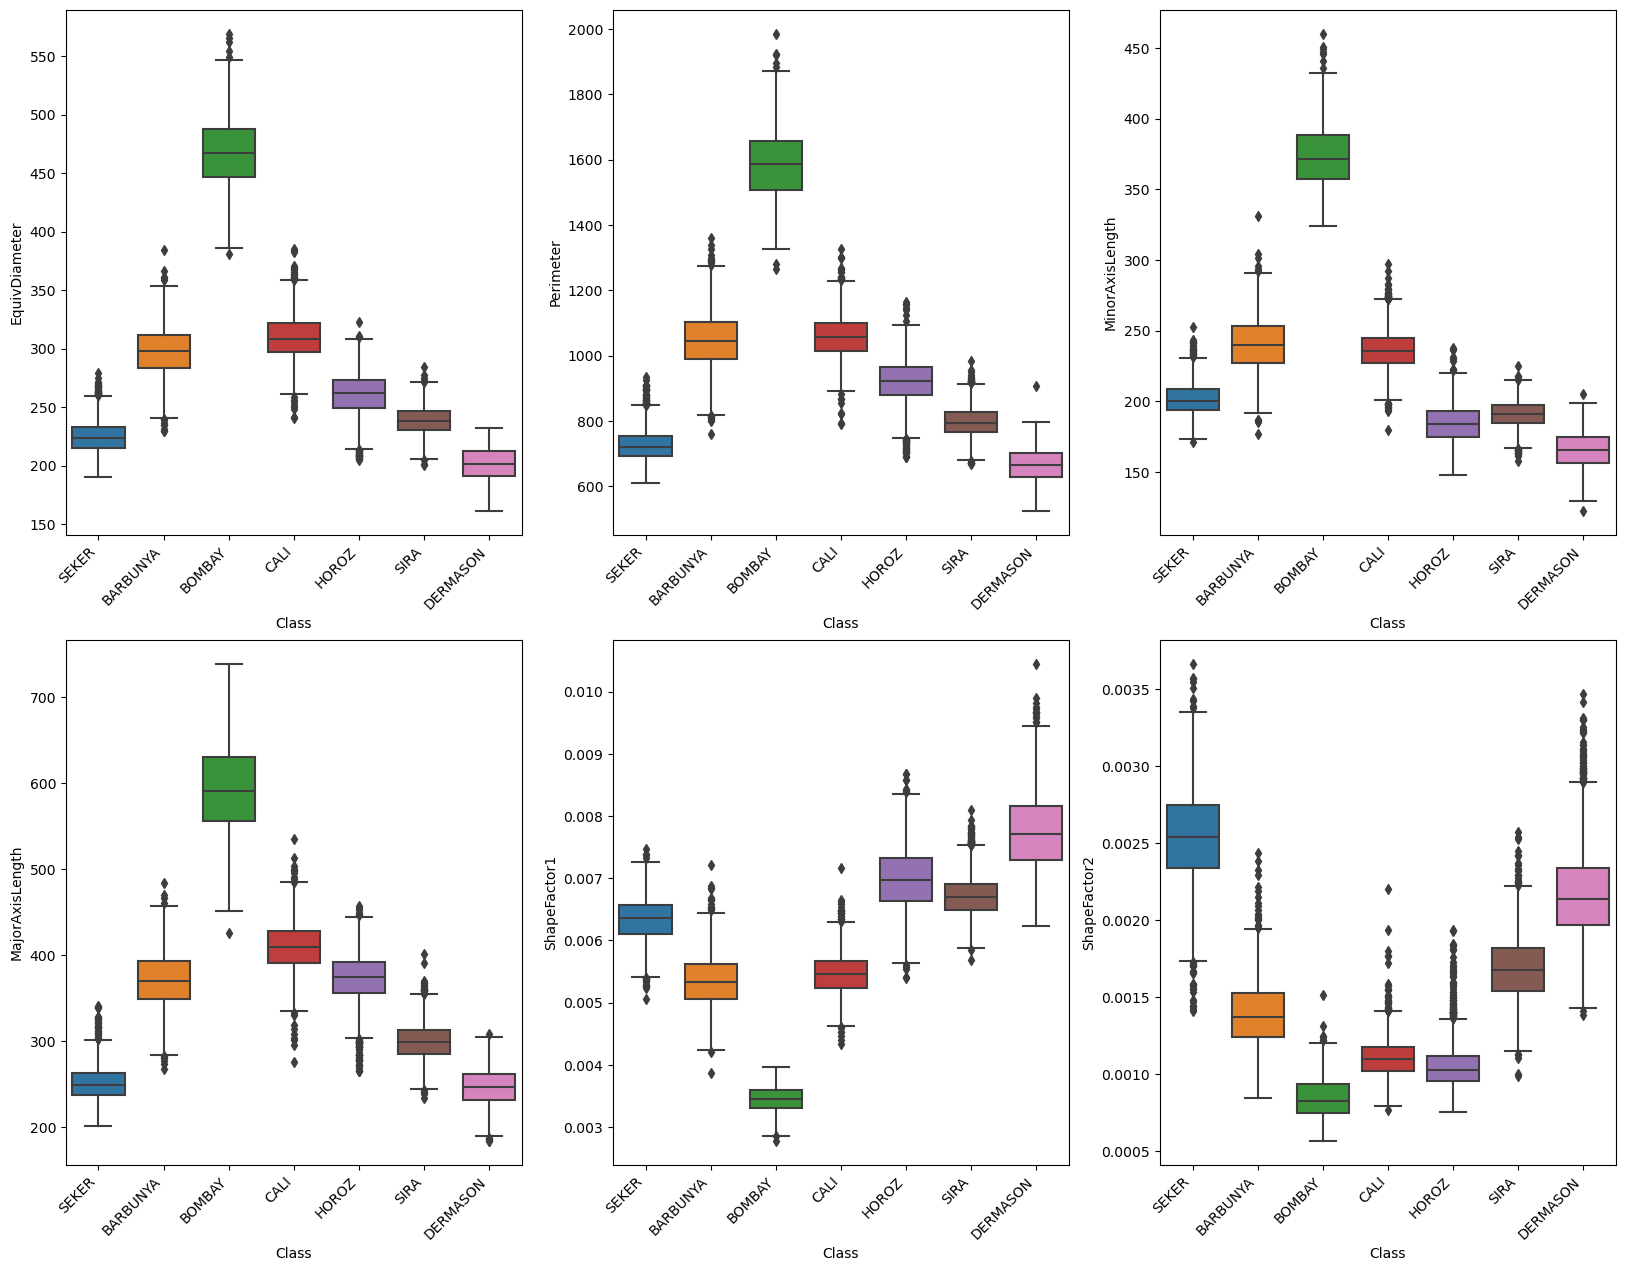

In [24]:
fig, axes = plt.subplots(2, 3)
plt.rcParams["figure.figsize"] = [20,15]

sns.boxplot(data=bean_df, x='Class', y="EquivDiameter", ax=axes[0, 0])
sns.boxplot(data=bean_df, x='Class', y="Perimeter", ax=axes[0, 1])
sns.boxplot(data=bean_df, x='Class', y="MinorAxisLength", ax=axes[0, 2])
sns.boxplot(data=bean_df, x='Class', y="MajorAxisLength", ax=axes[1, 0])
sns.boxplot(data=bean_df, x='Class', y="ShapeFactor1", ax=axes[1, 1])
sns.boxplot(data=bean_df, x='Class', y="ShapeFactor2", ax=axes[1, 2])

for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

# I. Aggregated table for the area per class.

Since we are tasked with creating an aggregated table for the area per class, I created a function that identifies outliers within a given DataFrame and feature of interest.

In [27]:
# Defining a function to detect outliers
def get_outliers(df, feature, include_quants=False):
    # Calculating the iqr-interval (q1 to q3)
    q1 = df[feature].quantile([0.25]).values[0]
    q3 = df[feature].quantile([0.75]).values[0]
    
    # Calculating the iqr and boxplot min/max
    iqr = q3 - q1
    box_min = q1 - (1.5*iqr)
    box_max = q3 + (1.5*iqr)
    
    outliers = df[(df[feature] < box_min) | (df[feature] > box_max)]
    
    if include_quants:
        return q1, q3, outliers
    else:
        return outliers

Creating an aggregated table for 'area' per 'class'...

In [28]:
# Creating a DataFrame that groups the bean dataset by 'Class'
area_df = bean_df.groupby('Class')['Area'].agg(['mean', 'std', 'count'])

ci80_lower = []
ci80_upper = []
iqr_q1 = []
iqr_q3 = []
outlier_count = []

# Iterates over the seven classes
for i in area_df.index:
    mean, std, count = area_df.loc[i]
    
    # Calculating the 80th-confidence interval
    ci80_lower.append(mean - 1.28*std/math.sqrt(count))
    ci80_upper.append(mean + 1.28*std/math.sqrt(count))
    
    # Separates information for the given class
    area_i = bean_df.loc[bean_df['Class'] == i]
    
    # Getting iqr-intervals (q1, q3) and outliers
    q1, q3, outliers = get_outliers(area_i, 'Area', include_quants=True)
    iqr_q1.append(q1)
    iqr_q3.append(q3) 
    outlier_count.append(outliers.shape[0])

# Adding in the columns of the information we've gathered
area_df['ci80_lower'] = ci80_lower
area_df['ci80_upper'] = ci80_upper
area_df['iqr_q1'] = iqr_q1
area_df['iqr_q3'] = iqr_q3
area_df['outlier_count'] = outlier_count

area_df

,mean,std,count,ci80_lower,ci80_upper,iqr_q1,iqr_q3,outlier_count
Class,,,,,,,,
BARBUNYA,69804.133132,10265.386454,1322,69442.748611,70165.517652,62931.00,76306.50,12
BOMBAY,173485.059387,23327.688116,522,172178.147168,174791.971606,156711.25,186599.00,7
CALI,75538.211043,9379.881487,1630,75240.829837,75835.592249,69343.50,81304.75,29
DERMASON,32118.710942,4676.129470,3546,32018.196809,32219.225075,28549.25,35581.00,0
HOROZ,53648.508817,7341.397869,1928,53434.498251,53862.519384,48909.75,58573.50,23
SEKER,39881.299951,4779.877395,2027,39745.406085,40017.193816,36408.00,42700.00,37
SIRA,44729.128604,4546.769886,2636,44615.773719,44842.483489,41612.00,47772.00,14


# Multilinear regression models.

While building my models, I noticed that outliers had a notable effect on model performance and removing them made a clear difference in the distribution curve of my models' residuals. It can also be seen from the box plots above that certain features have a multitude of outliers that can affect both regression and classification problems. I will be excluding outliers when building my regression and classifications models, as there are certain features that have a lot of points that go beyond the whiskers of the boxplots when plotting the features' distributions. In total, there were 148 outliers that I chose to remove from the dataset.

In [29]:
# Creating an empty DataFrame to contain the outliers within top regressors
top_regressors_outliers = pd.DataFrame(columns=bean_df.columns)

regressors = ['EquivDiameter', 'Perimeter', 'MinorAxisLength', 'MajorAxisLength', 'ShapeFactor1', 'ShapeFactor2']
beans_list = ['BARBUNYA', 'SEKER', 'BOMBAY']

for i in beans_list:
    
    bean_i = bean_df.loc[bean_df['Class'] == i]
    
    for regressor in regressors: 
        
        # Just getting the outliers, no quantiles
        outliers = get_outliers(bean_i, regressor, include_quants=False) 
        top_regressors_outliers = pd.concat([top_regressors_outliers, outliers], ignore_index=False)

# Getting the index of the rows with outliers
top_regressors_outliers.columns = top_regressors_outliers.columns.str.lower()
index_to_drop = top_regressors_outliers.index
print(len(index_to_drop.unique()))

148


### Creating a function to load in the dataset:

To facilitate our analysis, I created a function that loads in the dataset and makes a few changes to the DataFrame. I changed the data type of 'class' to 'category' to signal to Python that it is a categorical feature, since it will be the target variable in our classification models later on. I also set a parameter exclude_cols, which drops 'convexarea' and 'class' since both of our regression models will be built without these features, and I included remove_outliers so that outliers can be included/excluded to compare the differences in the results.

In [30]:
def bean(exclude_cols=True, remove_outliers=False):
    
    # Reading 'Dry_Bean_Dataset.xlsx' into a DataFrame
    bean_df = pd.read_excel(path_to_file)
    # Editing columns names
    bean_df.columns = bean_df.columns.str.lower()
    # Changing dtype of 'class'
    bean_df['class'] = bean_df['class'].astype('category')
    
    if remove_outliers:
        bean_df = bean_df.drop(set(index_to_drop))
        
    if exclude_cols:
        bean_df.drop(columns=['convexarea', 'class'], inplace=True)
    
    return bean_df

### Creating a function to preprocess the data:

Since all of our models will need to go through similar preprocessing steps, I created a function that will implement the typical steps that we go through as well as other feature engineering techniques that I wanted to test across the different models. Scaling the features is almost always necessary, but since the other feature engineering/transformation methods are going to be played with, I set parameters with default values that can be overridden when calling the function. 


| Parameter | Definition |
| :--- | :--- |
| use_poly | Polynomial transformation for multilinear regression using PCA |
| use_pca | PCA transformation for multilinear regression using PCA |
| poly_cap | Polynomial transformation for multlinear regression (no PCA) |
| use_pca_clf | PCA transformation for multiclass classfication |
| n_components | number of PCA components to include in multiclass classification |
| use_smote | SMOTE technique for multiclass classification |

In [12]:
def preprocessed_data(X_train, X_test, y_train,
                      use_poly=False, use_pca=False,
                      poly_cap=False, use_pca_clf=False,
                      n_components=1, use_smote=False):
    
    # Scaling the features
    scaler_model = StandardScaler()
    scaler_model.fit(np.array(X_train))
    X_train_scaled = scaler_model.transform(np.array(X_train)) 
    X_test = scaler_model.transform(np.array(X_test)) 
    
    # Implementing polynomial transformation for ridge regression
    if poly_cap:
        poly_model = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
        poly_model.fit(X_train_scaled)
        X_train_scaled = poly_model.transform(X_train_scaled)
        X_test = poly_model.transform(X_test)

        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, np.array(y_train))

        rfe = RFE(lr_model, n_features_to_select=3)
        rfe.fit(X_train_scaled, y_train)

        top_3_features = rfe.get_support(indices=True)

        poly_feature_names = poly_model.get_feature_names_out(X_train.columns)
        top_3_features_names = [poly_feature_names[i] for i in top_3_features]

        X_train_df = pd.DataFrame(X_train_scaled, columns=poly_model.get_feature_names_out(X_train.columns))
        X_train_top = X_train_df[top_3_features_names]
        X_test_df = pd.DataFrame(X_test, columns=poly_model.get_feature_names_out(X_train.columns))
        X_test_top = X_test_df[top_3_features_names]

        return X_train_top, X_test_top
    
    # Implementing polynomial transformation for linear regression
    if use_poly:
        poly_model = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
        poly_model.fit(X_train_scaled)
        X_train_scaled = poly_model.transform(X_train_scaled)
        X_test = poly_model.transform(X_test)
    
    # Implementing PCA transformation
    if use_pca:
        pca_model = PCA(n_components=3)
        pca_model.fit(X_train_scaled)
        X_train_scaled = pca_model.transform(X_train_scaled)
        X_test = pca_model.transform(X_test)
        
        selected_components = [0, 1, 2]
        
        X_train_scaled = X_train_scaled[:, selected_components]
        X_test = X_test[:, selected_components]
            
        return X_train_scaled, X_test
    
    n_pc = n_components
    if use_pca_clf:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train_scaled)
        X_train_scaled = pca_model.transform(X_train_scaled)
        X_test = pca_model.transform(X_test)
        
        selected_components = [i for i in range(0, n_pc)]
        
        X_train_scaled = X_train_scaled[:, selected_components]
        X_test = X_test[:, selected_components]
        
        if not use_smote:
            return X_train_scaled, X_test, y_train

### Creating a regression function:

This function will allow us to choose whether we want to use a regular linear regression or a ridge regression. The two options take in different parameters, and each will be useful in the different contexts of the two models we are building. 

Since the first model allows the use of PCA, we are able to address multicollinearity between the top regressors through this technique. However, since we are not able to use PCA in the second model, we introduce the ridge regression model, which is well suited for correlated regressors as it uses L2 regularization to penalize the differences in the predicted values and the actual values.

In [13]:
def linear_reg(X_train, X_test, y_train, y_test, 
               plot_residuals=False,
               model_type='linear',
               alpha=1):
    
    # Building the model
    if model_type == 'linear':
        linear_model = LinearRegression()
    elif model_type == 'ridge':
        alpha_param = alpha
        linear_model = Ridge(alpha=alpha_param)
        
    linear_model.fit(X=X_train, y=np.array(y_train))
    y_true = np.array(y_test)
    y_pred = linear_model.predict(X=X_test)
    
    # Finding R squared values and RMSE
    train_r2_score = linear_model.score(X=X_train, y=np.array(y_train))
    test_r2_score = linear_model.score(X=X_test, y=y_true)
    RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    residuals = y_true - y_pred
    
    if plot_residuals:
        plt.rcParams["figure.figsize"] = [7, 2]
        plt.rcParams["figure.autolayout"] = True
        sns.kdeplot(data=residuals, color='blue', fill=True, alpha=0.2, legend=False);
        sns.kdeplot(x=np.random.normal(scale=RMSE, size=100000), fill=True, alpha=0.2, color='purple');

    return train_r2_score, test_r2_score, RMSE, residuals

### Creating a k-fold cross validation function:

Our cross validation function will take in different parameters for the setting of the different models. We will have parameters for the use of polynomial transformation, PCA, a "capped" polynomial transformation (where we perform polynmial transformation and select the top three features after doing so), and model type (which can either be 'linear' or 'ridge').

In [14]:
def cross_validate(X, y, use_poly=False, use_pca=False, 
                   poly_cap=False, model_type='linear'):
    
    # Splitting the data into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=145)

    # Setting the k-fold cross-validation parameters
    cv = RepeatedKFold(n_splits=5, random_state=12345, n_repeats=100)
    splitting = cv.split(X=X_train, y=y_train)

    RMSEs = []
    train_r2_scores = []
    test_r2_scores = []
    
    model_type_param = model_type
    n_pc = n_components
    problem_type = problem

    for train_index, test_index in splitting:
    
        X_subtraining = X_train.iloc[train_index, :].copy()
        X_subtesting = X_train.iloc[test_index, :].copy()
        y_subtraining = np.array(y_train.iloc[train_index])
        y_subtesting = np.array(y_train.iloc[test_index])
        
        if use_poly:
            poly_bool = True
        else:
            poly_bool = False
        
        if use_pca:
            pca_bool = True
        else:
            pca_bool = False
        
        if poly_cap:
            poly_cap_bool = True
        else:
            poly_cap_bool = False

        X_subtraining, X_subtesting = preprocessed_data(X_subtraining, X_subtesting, y_subtraining,
                                                        use_poly=poly_bool, use_pca=pca_bool,
                                                        poly_cap=poly_cap_bool)


        if model_type_param == 'linear':
            train_r2, test_r2, RMSE, residuals = linear_reg(X_subtraining, X_subtesting, 
                                                            y_subtraining, y_subtesting,
                                                            model_type=model_type_param)
        if model_type_param == 'ridge':
            train_r2, test_r2, RMSE, residuals = linear_reg(X_subtraining, X_subtesting, 
                                                           y_subtraining, y_subtesting,
                                                           model_type=model_type_param,
                                                           alpha=0.000055)

        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
        RMSEs.append(RMSE)

        return np.mean(train_r2_scores), np.mean(test_r2_scores), np.mean(RMSEs)
            

As seen previously, I noted that there were six features that are highly correlated with the target variable 'Area', which are: 'EquivDiameter', 'Perimeter', 'MinorAxisLength', 'MajorAxisLength', 'ShapeFactor1', 'ShapeFactor2'.

In order to decide which features to include, I created two lists of the features going from high to low in terms of correlations to the target and in terms of variance. We want features with high correlation to the target, and features with high variance are often good predictors as well since more differences in the data make it easier for the model to make better predictions. Essentially, if a feature has low variance, most of the values would be around the same values, which wouldn't help the model much in making choices for predictions.

In [15]:
# List of the features (without including )
high_corr_cols = bean(exclude_cols=True).corrwith(bean()['area']).abs().sort_values(ascending=False).index.tolist()[1:]
high_var_cols = bean(exclude_cols=True).var().sort_values(ascending=False).index.tolist()[1:]

To choose the top performing regression models, I created for loops based on the high_corr_cols and high_var_cols. I started with the top three regressors from each, and then added the next highest one by one, until all features were considered for the models. After testing both, I found the optimal parameters for the two regression models that we are building, which I will test and validate below.

# II. Multilinear regression + PCA with 3 regressors.

### Building and choosing a model:

For this model, we will use the standard linear regression model, and use 'equivdiameter', 'perimeter', 'minoraxislength', and 'majoraxislength' as our features. Here, we are applying polynomial transformation and then PCA, and we are selecting the top 3 components that result, so we are using 3 regressors at the end!

### Testing the model: 

R^2: 0.9990871004916944
RMSE: 890.0114348379699


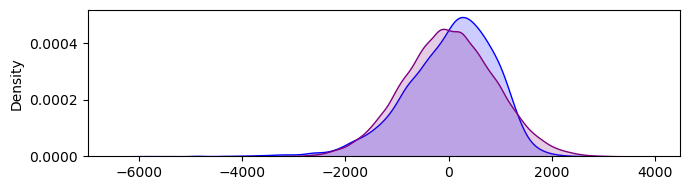

In [16]:
# Defining the feature and target
X = bean(exclude_cols=True, remove_outliers=True).drop(columns=['area'])[['equivdiameter', 'perimeter', 'minoraxislength', 'majoraxislength']]
y = bean(remove_outliers=True)['area'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=145)

X_train, X_test = preprocessed_data(X_train, X_test, y_train,
                                    use_poly=True, use_pca=True)
    

train_r2, test_r2, RMSE, residuals = linear_reg(X_train, X_test, y_train, y_test,
                                                plot_residuals=True,
                                                model_type='linear');

print(f"R^2: {test_r2}\nRMSE: {RMSE}")

### Validating the model:

In [17]:
train_r2, test_r2, RMSE = cross_validate(X, y, use_poly=True, use_pca=True, poly_cap=False, model_type='linear')
print(f"train_R^2: {train_r2}\ntest_R^2: {test_r2}\nRMSE: {RMSE}")

train_R^2: 0.9990403625402141
test_R^2: 0.9990974596627867
RMSE: 882.8412565933018


As we can see above, testing and validating the model gave extremely strong results! The R squared in the validation is similar to the test R square of 99.9% and we have a low RMSE value of approximately 882. More importantly, we can see that the distribution of the resisuals if close to normal, with a very slight left skew. I noted that different combinations of features included in the original feature matrix and number of polynimal terms gave very diverse results, and this set of parameters provided the best results.

# III. Multilinear regression with 3 regressors (no PCA).

### Building and choosing the model:

I chose a Ridge Regression because it can handle multicollinearity without the use of PCA. I experimented with different levels of alpha, and although an alpha of 0 is essentially a regular least squares regression, the alpha value that I chose ended up working extremely well with the data. I also tested the inclusion of different features based on correlations and variances as mentioned above, and I played around with the parameters in the polynomial transformation function. In the first model, it was better if we only included interaction terms as polynomial features, however, in this second model, it we got much better results when we did not limit polynomial terms to just interaction terms. This is likely because the second model works well despite multicollinearity, while the first model uses PCA to aggregate features. Aggregating a large amount of features through PCA might have made the components not as effective in capturing the most important data within the features.

### Testing the model:

R^2: 0.999999999999995
RMSE: 0.0020887593130744036


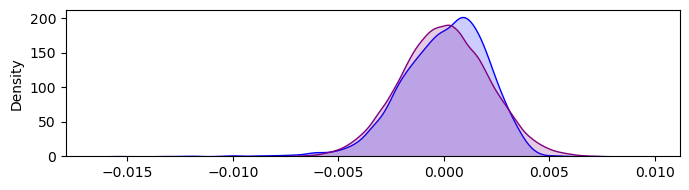

In [18]:
# Defining the feature and target
X = bean(exclude_cols=True, remove_outliers=True).drop(columns=['area'])[['equivdiameter', 'perimeter', 'minoraxislength']]
y = bean(remove_outliers=True)['area'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=145)

X_train, X_test = preprocessed_data(X_train, X_test, y_train,
                                    use_poly=False, use_pca=False, poly_cap=True)

# Building the ridge regression model
train_r2, test_r2, RMSE, residuals = linear_reg(X_train, X_test, y_train, y_test,
                                                plot_residuals=True,
                                                model_type='ridge',
                                                alpha=0.000055);

print(f"R^2: {test_r2}\nRMSE: {RMSE}")

### Validating the model:

In [19]:
# Running a cross-fold validation:
train_r2, test_r2, RMSE = cross_validate(X, y, use_poly=False, use_pca=False, poly_cap=True, model_type='ridge')
print(f"train_R^2: {train_r2}\ntest_R^2: {test_r2}\nRMSE: {RMSE}")

train_R^2: 0.9999999999999972
test_R^2: 0.9999999999999974
RMSE: 0.001483271395242684


As we can see, the model works extremely well, with R squares of 99.9% and an extremely low RMSE. We can also see that the distribution of the residuals is still slightly skewed to the left, but still resembles a normal curve!

# IV. Identifying 3 adequate learners for class.

Looking at the box plots for 'majoraxislength', 'perimeter', and 'equivdiameter', I noticed that the boxes for class DERMASON was lower than the boxes for class SIRA. I decided to create a feature that summed the three features up in order to add a little more data to the algorithm that may help differentiate DERMASON and SIRA. 

Note: Picking different features to include typically did not improve the scores of the logistic regression. I tried adding features incrementally, and checking [1, n_features] components as I looped over the features one by one, however, scores were always higher when there were more features included.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

X = bean(exclude_cols=False, remove_outliers=True).drop(columns=['class'])
y = bean(exclude_cols=False, remove_outliers=True)['class'].copy()

# Adding a feature
X['sum_of_features'] = X.apply(lambda row: row['majoraxislength'] + row['perimeter'] + row['equivdiameter'], axis=1)

To begin, I will create a function that calls the different learners I studied for the multiclass classification problem. I chose logistic regression, KNN, and Random Forest. This function will allow us to tune the number of principal components utilized in the model. 

In [21]:
def clf_model(X_train, X_test, y_train, y_test,
              model_type='logistic', n_components=1,
              matrix_display=False):
    
    n_pc = n_components
    if matrix_display:
        show_matrix = True
    else:
        show_matrix = False
    
    if model_type == 'logistic':
        clf_model = LogisticRegression(random_state=2023, 
                                      max_iter=5000,
                                      C=50, 
                                      n_jobs=-1,
                                      class_weight='balanced',
                                      multi_class='multinomial')
    if model_type == 'knn':
        clf_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
        
    if model_type == 'rf':
        clf_model = RandomForestClassifier(n_estimators=100, 
                                random_state=42,
                                max_features=n_pc)
        
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    y_pred_proba = clf_model.predict_proba(X_test)
    log_loss_score = log_loss(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    
    if show_matrix:
        test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
        return test_accuracy, log_loss_score, test_confusion_matrix
    
    return test_accuracy, log_loss_score

    

# V. Attempts to optimize the top-learner.

We will test the range of components we can include. When using PCA, the maximum number of components we can use is min(n_features, n_samples). The number of samples is the number of rows, which is extremely large around 13,000, and the number of features is 16. So, we will test the range [1, 16] for the number of components, tracking the test accuracy and log loss scores.

In [22]:
components = range(1, 17)
accuracies_logistic = []
accuracies_knn = []
accuracies_rf = []

log_loss_logistic = []
log_loss_knn = []
log_loss_rf = []

In [23]:
for i in components:
    
    n_pc = i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, 
                                                    random_state=145,
                                                   stratify=y)

    X_train, X_test, y_train = preprocessed_data(X_train, X_test, y_train,
                                            use_pca_clf=True, n_components=n_pc)

    # Training a logisitic regression model
    test_accuracy_log, log_loss_score_log = clf_model(X_train, X_test, y_train, y_test,
                                              model_type='logistic', n_components=n_pc)

    accuracies_logistic.append(test_accuracy_log)
    log_loss_logistic.append(log_loss_score_log)
    
    # Training a knn model
    test_accuracy_knn, log_loss_score_knn = clf_model(X_train, X_test, y_train, y_test,
                                              model_type='knn', n_components=n_pc)
    
    accuracies_knn.append(test_accuracy_knn)
    log_loss_knn.append(log_loss_score_knn)
    
    # Training a rf model
    test_accuracy_rf, log_loss_score_rf = clf_model(X_train, X_test, y_train, y_test,
                                              model_type='rf', n_components=n_pc)

    accuracies_rf.append(test_accuracy_rf)
    log_loss_rf.append(log_loss_score_rf)

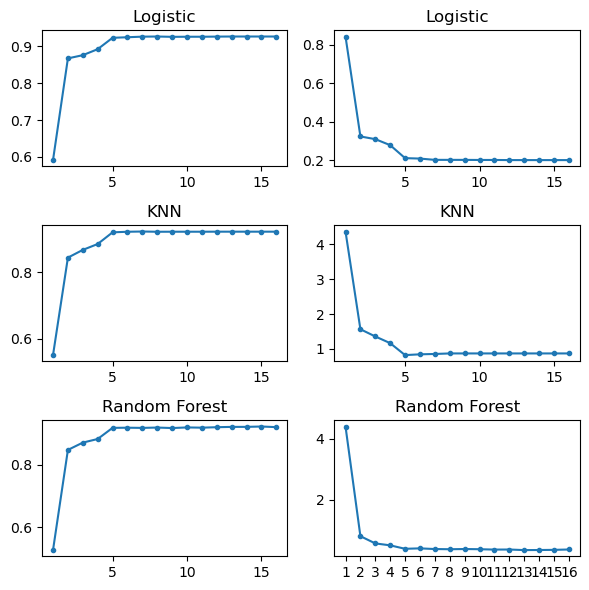

In [27]:
fig, ax = plt.subplots(3, 2)
plt.rcParams["figure.figsize"] = [7, 9]

ax[0, 0].plot(components, accuracies_logistic, marker='o', markersize=3)
ax[0, 0].title.set_text('Logistic')
ax[1, 0].plot(components, accuracies_knn, marker='o', markersize=3)
ax[1, 0].title.set_text('KNN')
ax[2, 0].plot(components, accuracies_rf, marker='o', markersize=3)
ax[2, 0].title.set_text('Random Forest')

ax[0, 1].plot(components, log_loss_logistic, marker='o', markersize=3)
ax[0, 1].title.set_text('Logistic')
ax[1, 1].plot(components, log_loss_knn, marker='o', markersize=3)
ax[1, 1].title.set_text('KNN')
ax[2, 1].plot(components, log_loss_rf, marker='o', markersize=3)
ax[2, 1].title.set_text('Random Forest')

plt.xticks(components)

plt.show()

Above, we can see that all of the algorithms have a high accuracy after the number of components is at 5 or above. The right side of the plot shows the log loss scores, where we can see that the logistic regression provides the best results.

Therefore, I will cross validate with 5 components on the logistic regression.

In [25]:
def cross_validate_clf(X, y, use_pca_clf=False, 
                       n_components=i,
                       model_type='logistic'):
    
    # Splitting the data into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=145)

    # Setting the k-fold cross-validation parameters
    cv = RepeatedKFold(n_splits=5, random_state=12345, n_repeats=100)
    splitting = cv.split(X=X_train, y=y_train)

    test_r2_scores = []
    log_loss_scores = []
    confusion_matrices = []
    
    n_pc = n_components
    model_type_param = model_type

    for train_index, test_index in splitting:
    
        X_subtraining = X_train.iloc[train_index, :].copy()
        X_subtesting = X_train.iloc[test_index, :].copy()
        y_subtraining = np.array(y_train.iloc[train_index])
        y_subtesting = np.array(y_train.iloc[test_index])
        
        if use_pca_clf:
            pca_bool = True
        else:
            pca_bool = False
                
    X_subtraining, X_subtesting, y_subtraining = preprocessed_data(X_subtraining, X_subtesting, 
                                                                   y_subtraining, use_pca_clf=pca_bool, 
                                                                   n_components=n_pc)

    # Training a logisitic regression model
    test_accuracy, log_loss_score, test_matrix = clf_model(X_subtraining, X_subtesting, 
                                              y_subtraining, y_subtesting,
                                              model_type=model_type_param, 
                                              n_components=n_pc,
                                              matrix_display=True)

    test_r2_scores.append(test_accuracy)
    log_loss_scores.append(log_loss_score)
    confusion_matrices.append(test_matrix)
    
    conf_matrix = np.round(sum(confusion_matrices)/len(confusion_matrices), decimals=2)

    return np.mean(test_r2_scores), np.mean(log_loss_scores), conf_matrix
    
    

test_R^2: 0.921443736730361
log_loss: 0.2239026655703183


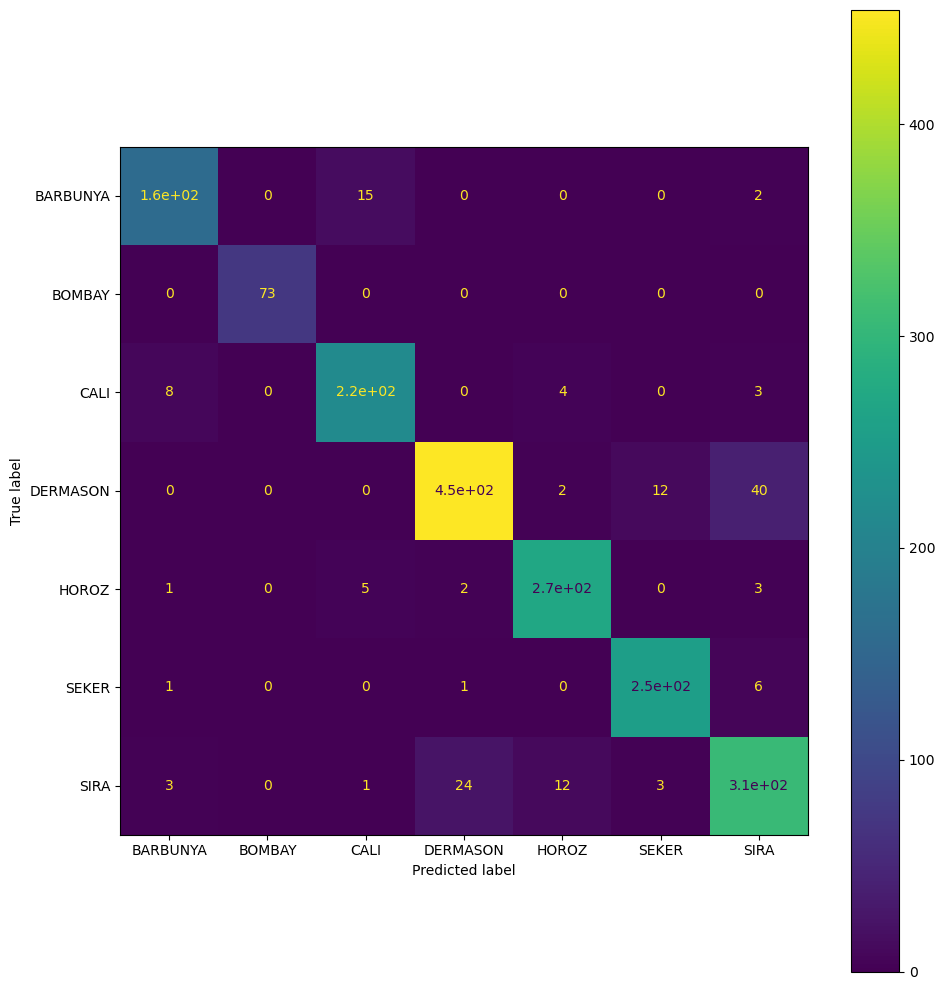

In [30]:
test_r2, log_loss_score, conf_matrix = cross_validate_clf(X, y, use_pca_clf=True,
                                             n_components=5,
                                             model_type='logistic')
print(f"test_R^2: {test_r2}\nlog_loss: {log_loss_score}")
plt.rcParams["figure.figsize"] = [10, 10]
ConfusionMatrixDisplay(conf_matrix, display_labels=['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']).plot();

Based on the cross validation, we can see that the logistic model performs very well! The R squared is relatively high at 92% and the low log loss score indicates that the model is relatively confident in its predictions.

# Conclusion

Through this project, we were able to observe the different applications of PCA, polynomial transformation, and feature selection for multilinear regression and muticlass classification problems. Noting the diffences in results when the parameters for each technique was tuned demonstrated that even minute changes within each feature engineering technique can cause a vast change in the results of the model.

Therefore, we want to consider the characteristics of the features we are given, in relation to each other as well as with the target, especially when we are restricted in building our model to the use of PCA or limitations on the number of regressions. Additionally, for our classification models, we especially want to look at the log loss scores to identify which model is most confident in its predictions, as the R squared values and matrices can look the same. 